In [1]:
import sys  
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [2]:
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0) 
        self.cov = None #変更
        
    def draw(self, ax, elems): 
        if self.cov is None:
            return
        
        ##推定位置に青い星を描く##
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ##誤差楕円を描く##
        e = sigma_ellipse(self.pos, self.cov, 3)
        elems.append(ax.add_patch(e))

In [3]:
class MapParticle(Particle):  
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
            
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        landmark.pos = z[0]*np.array([np.cos(self.pose[2] + z[1]), np.sin(self.pose[2]  + z[1])]).T + self.pose[0:2]
        H = matH(self.pose, landmark.pos)[0:2,0:2]             #カルマンフィルタのHの左上2x2を取り出す
        Q = matQ(distance_dev_rate*z[0], direction_dev)
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H))
        
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):
        estm_z = IdealCamera.observation_function(self.pose, landmark.pos) #ランドマークの推定位置から予想される計測値
        if estm_z[0] < 0.01:  # 推定位置が近すぎると計算がおかしくなるので回避
            return

        H = - matH(self.pose, landmark.pos)[0:2,0:2] #ここは符号の整合性が必要
        Q = matQ(distance_dev_rate*estm_z[0], direction_dev)
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ##重みの更新#           ###fastslam5
        Q_z = H.dot(landmark.cov).dot(H.T) + Q                                                    #追加
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)    #追加
        
        ##ランドマークの推定の更新##
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        
    def observation_update(self, observation, distance_dev_rate, direction_dev): 
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

In [4]:
class FastSlam(Mcl):
    def __init__(self, init_pose, particle_num, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
        
    def observation_update(self, observation):  
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #self.mapを削除
        self.set_ml()
        self.resampling() 
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

<IPython.core.display.Javascript object>


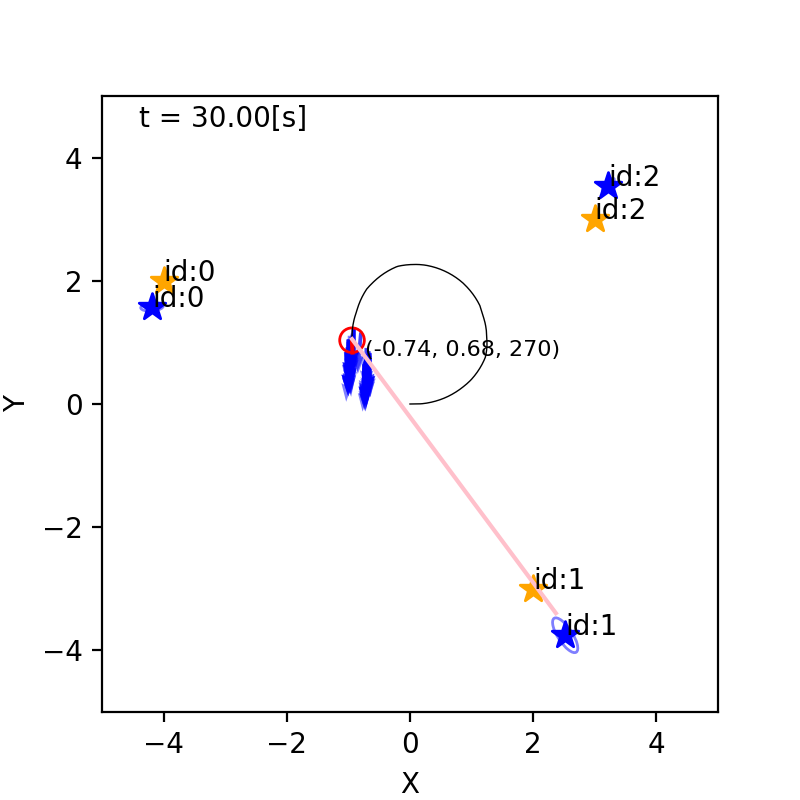

In [9]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ###真の地図を作成###
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = FastSlam(init_pose, 100, len(m.landmarks)) 
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
trial()

In [6]:
def trial():
    time_interval = 3
    world = World(30, time_interval, debug=False) 

    ###真の地図を作成###
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = FastSlam(init_pose, 100, len(m.landmarks)) 
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
#trial()